# Ecobici

## Import

In [1]:
import sys
sys.path.append('/Users/efraflores/Desktop/hub/diplo/venv/lib/python3.9/site-packages')

In [2]:
BASE_DIR = '/Users/efraflores/Desktop/EF/Corner/data/practice'

In [3]:
import os
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

df = pd.read_csv(os.path.join(BASE_DIR,'2021-04.csv'))
df.sample()

,Genero_Usuario,Edad_Usuario,Bici,Id_Usuario,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha Arribo,Hora Arribo
78237,F,42,9290,135056,240,08/04/2021,05:46:22,97,08/04/2021,06:14:10


In [4]:
geo = pd.read_csv(os.path.join(BASE_DIR,'estaciones-de-ecobici.csv'))
geo.sample()

,ID,Nombre,Dirección,Número,Código postal,districtCode,Colonia,altitude,nearbyStations/0,location/lat,location/lon,Tipo de estación,nearbyStations/1,nearbyStations/2,nearbyStations/3,nearbyStations/4,nearbyStations/5,punto_geo
268,51,51 COLIMA-OAXACA,051 - Colima - Oaxaca,S/N,6700.000,R-N,Roma Norte,NaN,46,19.418,-99.168,BIKE,47.000,55.000,58.000,NaN,NaN,"19.417995,-99.168248"


## Functions

In [5]:
import time
import numpy as np
from IPython.lib.display import Audio

#Start a "stopwatch"
start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

In [6]:
#Uncomment the next line if you don't have it installed yet, 
'''!pip install mpu'''

#it has the function to calculate the distance between two coordinates
import mpu

def transf(data):
    df = data.copy()
    df.columns = [str(x).strip().lower().replace(' ','_') for x in df.columns]
    for tipo in ['retiro','arribo']:
        #Merge de date and hour columns, and set is a datetime column
        df[f'fecha_{tipo}'] = pd.to_datetime(df[f'fecha_{tipo}']+','+df[f'hora_{tipo}'],
                                              format='%d/%m/%Y,%H:%M:%S')
        #Get the day of the week name, just the first 3 characters
        df[f'dow_{tipo}'] = df[f'fecha_{tipo}'].dt.day_name().str[:3]
        #Get the time as hour-decimal. Ex: 15:30 --> 15.5
        df[f'hrmin_{tipo}'] = (df[f'fecha_{tipo}'].dt.hour+
                               df[f'fecha_{tipo}'].dt.minute/60+
                               df[f'fecha_{tipo}'].dt.second/60**2)
        #Make equally-distributed bins and save the bins
        df[f'hrmin_{tipo}_cut'],qbins = pd.qcut(df[f'hrmin_{tipo}'].apply(lambda x:round(x,3)),
                                                q=7,duplicates='drop',retbins=True)
        df[f'hrmin_{tipo}_cut'] = df[f'hrmin_{tipo}_cut'].astype(str)
        #Get the geo-points from the origin and destination stations
        df = df.merge(geo.set_index('ID')['punto_geo'].str.split(',').to_frame().reset_index(),
                      left_on=f'ciclo_estacion_{tipo}',right_on='ID'
                     ).drop(columns='ID').rename(columns={'punto_geo':f'geo_{tipo.lower()}'})
    #Calculate the ridetime in hours
    df['ridetime'] = df['hrmin_arribo'] - df['hrmin_retiro']
    #There were few trips at midnight (why?)
    df = df[df['ridetime']>0].copy()
    #Distance in km between the destination vs the origin station 
    df['distance'] = [mpu.haversine_distance(tuple([float(a) for a in x]),tuple([float(a) for a in y]))
                      for x,y in zip(df['geo_retiro'],df['geo_arribo'])]
    #Velocity of every ride in km/hr
    df['velocity'] = df['distance'] / df['ridetime']
    #Get rid of unnecesary columns
    df.drop(columns=['hora_retiro','hora_arribo','geo_retiro','geo_arribo'],inplace=True)
    return df,qbins

In [7]:
def iqr(data,x,p=0.3):
    var = data[x].copy()
    q1 = var.quantile(p/2)
    q3 = var.quantile(1-p/2)
    iqr = q3 - q1
    return data[(var.isnull()) | ((var >= q1 - 1.5*iqr) & (var <= q3 + 1.5*iqr))].copy()

In [8]:
def perc70(x):
    return np.percentile(x,70)

In [9]:
def multishift(data,id_cols,date_col,shifts,**pivot_args):
    df = data.copy()
    #Make sure the col just have the date (without time)
    df[date_col] = df[date_col].dt.date
    #Merge all column names as a string
    id_col = ','.join(id_cols)
    #And as a column
    df[id_col] = df[id_cols].apply(lambda x:','.join(x.dropna().astype(str)),axis=1)
    #Drop any "id_col"-set that has a lower frequency than the max of the "shifts-list"
    freq = df[id_col].value_counts().to_frame()
    omit_idx = freq[freq[id_col]<=max(shifts)].index.to_list()
    if len(omit_idx)>0:
        df = df[~df[id_col].isin(omit_idx)].copy()
    #Change data structure to build the "shifting"
    df = df.pivot_table(index=[id_col,date_col],
                        **pivot_args,
                        fill_value=0)
    #Concatenate multiple columns if they are
    df.columns = ['_'.join([x for x in col]) if 
                  not isinstance(df.columns[0],str) #First element is not a string
                  else col for col in df.columns]
    #Bring the id_col for taking the set (unique values) in the next loop
    df = df.reset_index()
    #Each shift must be calculated at "id_col" level
    total = pd.DataFrame()
    for row in set(df[id_col]):
        #Set the id_col as index (again) to call all the rows with that id_col
        df_id = df.set_index(id_col).loc[row,:]
        #All possible dates from the min to the max of the subset
        tot_dates = pd.DataFrame(pd.date_range(start=df_id[date_col].min(), 
                                               end=df_id[date_col].max()).date, 
                                 columns=[date_col])
        df_id = df_id.merge(tot_dates,on=date_col,how='right').fillna(0)
        cols = df_id.columns[1:]
        #Start the "shifting"
        aux = df_id.copy()
        for i in shifts:
            aux = aux.join(df_id.iloc[:,1:].shift(i).rename(columns={x:f'{x}_{str(i).zfill(2)}' 
                                                                     for x in cols}))
        aux[id_col] = row
        total = total.append(aux,ignore_index=True)
    return total.set_index(id_cols+[date_col])

## Transform

In [10]:
df,qbins = transf(df.rename(columns={'Ciclo_EstacionArribo':'ciclo_estacion_arribo'}))
df.sample()

,genero_usuario,edad_usuario,bici,id_usuario,ciclo_estacion_retiro,fecha_retiro,ciclo_estacion_arribo,fecha_arribo,dow_retiro,hrmin_retiro,hrmin_retiro_cut,dow_arribo,hrmin_arribo,hrmin_arribo_cut,ridetime,distance,velocity
161983,M,35,8930,342214,171,2021-04-12 05:55:23,166,2021-04-12 06:01:05,Mon,5.923,"(4.923, 6.577]",Mon,6.018,"(4.919, 6.657]",0.095,0.682,7.178


### Ridetime

<AxesSubplot:>

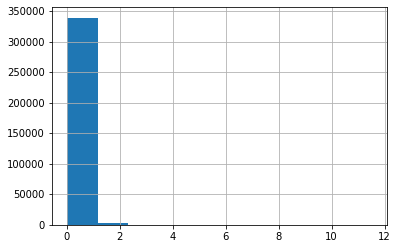

In [11]:
df['ridetime'].hist()

Omit outliers with the IQR method

<https://online.stat.psu.edu/stat200/lesson/3/3.2>

<AxesSubplot:>

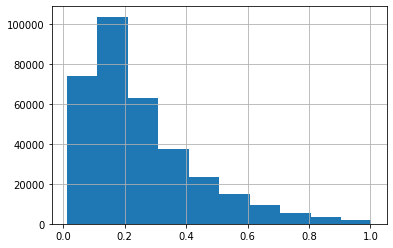

In [12]:
#Save the original length
dim_before = len(df)

df = iqr(df,'ridetime')
df['ridetime'].hist()

### Distance

<AxesSubplot:>

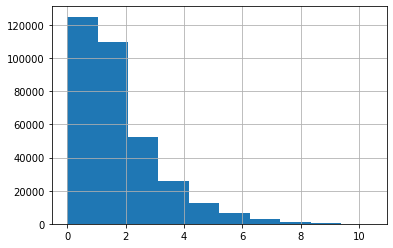

In [13]:
df['distance'].hist()

<AxesSubplot:>

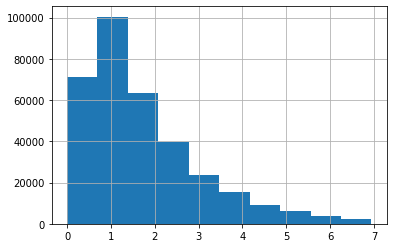

In [14]:
df = iqr(df,'distance')
df['distance'].hist()

### Velocity

<AxesSubplot:>

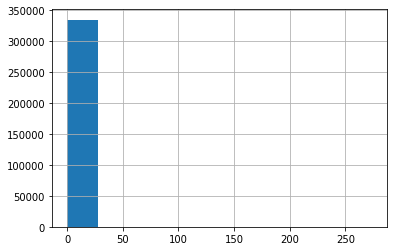

In [15]:
df['velocity'].hist()

<AxesSubplot:>

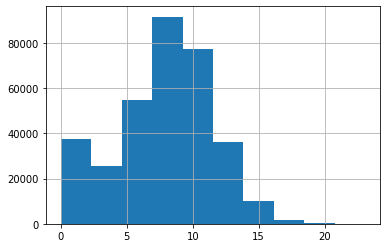

In [16]:
df = iqr(df,'velocity')
df['velocity'].hist()

### Age

<AxesSubplot:>

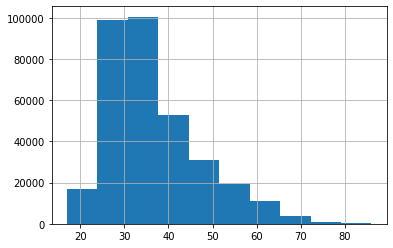

In [17]:
df['edad_usuario'].hist()

<AxesSubplot:>

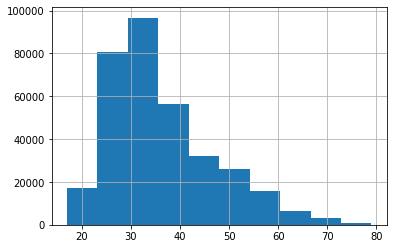

In [18]:
df = iqr(df,'edad_usuario')
df['edad_usuario'].hist()

In [19]:
#Does the outlier cleaning affect the data length?
print(len(df)/dim_before)

0.9777596772262949


### Demand

In [20]:
'''!pip install seaborn'''
import seaborn as sns

color = sns.light_palette('LightSkyBlue', as_cmap=True)

#This is how the demand (and their avg age) looks through the daytime vs day of the week
df.pivot_table(index='hrmin_retiro_cut',
               columns='dow_retiro',
               values='edad_usuario',
               aggfunc=['count','mean']).style.background_gradient(cmap=color).format('{:.1f}')
#But surely the demand does not distribute exactly the same along all stations

In [21]:
demand = df.pivot_table(index=['ciclo_estacion_retiro','hrmin_retiro_cut'],
                    columns='dow_retiro',
                    values='edad_usuario',
                    aggfunc='count',
                    fill_value=0).reset_index()
demand.sample()

dow_retiro,ciclo_estacion_retiro,hrmin_retiro_cut,Fri,Mon,Sat,Sun,Thu,Tue,Wed
863,126,"(2.941, 4.923]",25,17,13,11,31,14,24


In [22]:
demand.pivot_table(index='hrmin_retiro_cut',
                   values=demand.columns[-7:],
                   aggfunc=['median','mean',perc70]
                  ).T.style.background_gradient(cmap=color).format('{:.1f}')

## TAD

In [23]:
import seaborn as sns

color = sns.dark_palette("#69d", as_cmap=True)

tipo = 'arribo'
#Example of what this function does
multishift(data=df.head(9).append(df.tail(9)),
           id_cols=[f'ciclo_estacion_{tipo}'],
           date_col=f'fecha_{tipo}',
           shifts=[1,3,4],
           values='bici',aggfunc='count',
           #columns=['hrmin_retiro_cut']
           #columns=['hrmin_retiro_cut','hrmin_Arribo_cut'],
           #values=['bici','genero_usuario'],
           #aggfunc={'bici':['sum','mean'],'genero_usuario':'count'}
          ).style.background_gradient(cmap=color).format('{:.1f}')

In [24]:
df = multishift(data=df,
                id_cols=[f'ciclo_estacion_{tipo}'],
                date_col=f'fecha_{tipo}',
                shifts=range(1,10),
                columns=f'hrmin_{tipo}_cut',
                values='bici',
                aggfunc='count')
df.reset_index().to_csv(os.path.join(BASE_DIR,f'bicis_shift_{tipo}.csv'),index=False)

In [25]:
#Last step can take a lot of time, so we have now a backup file to not repeat that step
df = pd.read_csv(os.path.join(BASE_DIR,f'bicis_shift_{tipo}.csv'),index_col=[0,1]).dropna()
df.sample()

,,"(0.999, 2.973]","(10.903, 13.0]","(2.973, 4.919]","(4.919, 6.657]","(6.657, 7.992]","(7.992, 9.289]","(9.289, 10.903]","(0.999, 2.973]_01","(10.903, 13.0]_01","(2.973, 4.919]_01",...,"(6.657, 7.992]_08","(7.992, 9.289]_08","(9.289, 10.903]_08","(0.999, 2.973]_09","(10.903, 13.0]_09","(2.973, 4.919]_09","(4.919, 6.657]_09","(6.657, 7.992]_09","(7.992, 9.289]_09","(9.289, 10.903]_09"
ciclo_estacion_arribo,fecha_arribo,,,,,,,,,,,,,,,,,,,,,
174,2021-04-25,6.000,8.000,6.000,5.000,4.000,3.000,6.000,4.000,10.000,1.000,...,5.000,6.000,2.000,10.000,13.000,6.000,11.000,12.000,8.000,3.000


In [26]:
#Save the columns with the previous dates info
prev = df.head().filter(regex='_\d+').columns.tolist()
actual = [x for x in df.columns if x not in prev]
print(actual)

['(0.999, 2.973]', '(10.903, 13.0]', '(2.973, 4.919]', '(4.919, 6.657]', '(6.657, 7.992]', '(7.992, 9.289]', '(9.289, 10.903]']


## Daily Model

### Preprocessing

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = df[prev].copy()
y = df[actual].sum(axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    train_size=0.77,
                                                    random_state=22)
mm_x = MinMaxScaler()

### Arquitecture

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()

model_reg = Pipeline(steps=[('scaler', mm_x),
                            ('model', linear_reg)])

print('Score: ',model_reg.fit(X_train,y_train).score(X_test,y_test))
#The most relevant features to the model_reg
coef = pd.DataFrame(zip(X.columns,model_reg[1].coef_)).sort_values(1,0,0).reset_index(drop=True)
coef.head().append(coef.tail())

Score:  0.8620659183788816


,0,1
0,"(6.657, 7.992]_07",27.468
1,"(4.919, 6.657]_07",26.818
2,"(7.992, 9.289]_07",22.195
3,"(10.903, 13.0]_07",21.409
4,"(2.973, 4.919]_07",12.618
58,"(4.919, 6.657]_09",-2.776
59,"(6.657, 7.992]_05",-3.441
60,"(4.919, 6.657]_05",-4.167
61,"(7.992, 9.289]_02",-4.304
62,"(6.657, 7.992]_09",-6.193


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_jobs=-1,random_state=22)

model_forest = Pipeline(steps=[('scaler', mm_x),
                               ('model', forest)])

print(model_forest.fit(X_train,y_train).score(X_test,y_test))

#The most relevant features to the model_forest
pd.DataFrame(zip(X.columns,model_forest[1].feature_importances_)).sort_values(1,0,0).head(10).reset_index(drop=True)

0.8498626824254609


,0,1
0,"(4.919, 6.657]_07",0.244
1,"(6.657, 7.992]_07",0.189
2,"(7.992, 9.289]_07",0.080
3,"(2.973, 4.919]_07",0.058
4,"(9.289, 10.903]_07",0.055
5,"(10.903, 13.0]_07",0.034
6,"(2.973, 4.919]_01",0.020
7,"(10.903, 13.0]_01",0.018
8,"(0.999, 2.973]_07",0.018
9,"(9.289, 10.903]_01",0.013


'''pip install xgboost'''
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()

param_xgb = {'learning_rate':[x/100 for x in range(1,51,10)],
             'n_estimators':[x for x in range(100,1100,100)],
             'max_depth':[x for x in range(1,11)], 
             'min_child_weight':[x/10 for x in range(1,101,10)],
             'reg_lambda': [x/10 for x in range(1,101,10)]
            }
            
from sklearn.model_selection import RandomizedSearchCV
search_xgb = RandomizedSearchCV(param_distributions=param_xgb, 
                                cv=4,
                                n_jobs=-1, 
                                scoring='r2', 
                                estimator=xgb, 
                                verbose=1,
                                n_iter=70,
                                random_state=22)

model_xgb = Pipeline(steps=[('scaler',mm_x),
                            ('model',search_xgb)])

print(model_xgb.fit(X_train,y_train).score(X_test,y_test))

#The most relevant features to the model_xgb
pd.DataFrame(zip(X.columns,model_xgb[1].best_estimator_.feature_importances_)).sort_values(1,0,0).head(10).reset_index(drop=True)

### Predict

In [30]:
X.reset_index().join(pd.DataFrame(y,columns=['real'])
                    ).join(pd.DataFrame(model_reg.predict(X),columns=['est'])
                          ).to_csv(os.path.join(BASE_DIR,f'predict_daily_{tipo}.csv'),index=False)

### Save the model

In [31]:
import pickle
with open(os.path.join(BASE_DIR,f'bici_day_model_{tipo}.pkl'), 'wb') as f:
    pickle.dump((model_reg,[prev,actual]), f)

import pickle    
with open(os.path.join(BASE_DIR,f'bici_day_model_{tipo}.pkl'), 'rb') as f:
    modelo = pickle.load(f)

## End

In [32]:
time_exp(time.time() - start)
tone()

1 minutos con 2.69 segundos
